**I/O device register**

In [ ]:
!nvidia-smi

Fri Apr 23 20:08:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |   9376MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Install required libraries**

In [ ]:
!pip3 install transformers pandas nltk spacy classla

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html 


Looking in links: https://download.pytorch.org/whl/torch_stable.html


# Random seed

In [ ]:
import random
import numpy as np
import torch

seed_val = 2021

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# BERT 

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import pandas as pd
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import time
import datetime

In [ ]:
def setup_classifier(
    model_name: str,
    num_labels: int) -> BertForSequenceClassification:

    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels = num_labels,
        output_attentions = False,
        output_hidden_states = False,
    )
    
    return model

In [ ]:
def setup_data(
    model_name: str,
    x: pd.DataFrame, 
    y: pd.DataFrame,
    do_lower_case: bool,
    max_length: int) -> TensorDataset:

    tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = do_lower_case)

    input_ids = []
    attention_masks = []

    for text in x:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens = True,
            max_length = max_length,
            padding='max_length',
            return_attention_mask = True,
            return_tensors = 'pt',
            truncation = True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y)

    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [ ]:
def train_classifier(
    model: BertForSequenceClassification, 
    dataset: TensorDataset, 
    validation_ratio: float,
    batch_size: int,
    freeze_embeddings_layer: bool,
    freeze_encoder_layers: int,
    epochs: int,
    save_checkpoints: bool) -> (BertForSequenceClassification, list):

    device = select_device()

    train_size = int(validation_ratio * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size
    )

    validation_dataloader = DataLoader(
        val_dataset,
        sampler = SequentialSampler(val_dataset),
        batch_size = batch_size
    )

    modules = []

    if freeze_embeddings_layer:
        modules.append(model.bert.embeddings)
    
    for i in range(freeze_encoder_layers):
        modules.append(model.bert.encoder.layer[i])

    for module in modules:
        for param in module.parameters():
            param.requires_grad = False
    
    model.to(device)

    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr = 2e-5,
        eps = 1e-8
    )

    total_steps = len(train_dataloader) * epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )

    training_stats = []

    total_t0 = time.time()

    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        t0 = time.time()

        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = format_time(time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        

            outputs = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask, 
                labels = b_labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()

            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
        

        print("")
        print("Running Validation...")

        t0 = time.time()

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:
            
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():

                outputs = model(
                    b_input_ids, 
                    token_type_ids = None, 
                    attention_mask = b_input_mask,
                    labels = b_labels
                )
                
                loss = outputs.loss
                logits = outputs.logits
                
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

        if save_checkpoints:
            now = datetime.datetime.now()
            save_checkpoint(
                "drive/MyDrive/models/checkpoint_e" + str(epoch_i + 1) + "_" + str(now) + ".pt",
                model, optimizer, epoch_i, { "train": avg_train_loss, "val": avg_val_loss }
            )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

In [ ]:
def test_classifier(
    model: BertForSequenceClassification, 
    dataset: TensorDataset,
    batch_size: int):

    device = select_device()

    prediction_dataloader = DataLoader(
        dataset, 
        sampler = SequentialSampler(dataset), 
        batch_size = batch_size
    )

    print("")
    print("Running Prediction...")

    model.to(device)

    model.eval()

    predictions , true_labels = [], []

    for batch in prediction_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2]
        
        with torch.no_grad():

            outputs = model(
                b_input_ids, 
                token_type_ids = None, 
                attention_mask = b_input_mask
            )

        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.numpy()
        
        #predictions.append(logits)
        #true_labels.append(label_ids)
        predictions.extend(list(np.argmax(logits, axis=1).flatten()))
        true_labels.extend(list(label_ids))
    
    print('DONE.')

    return predictions, true_labels


In [ ]:
def save_checkpoint(path, model, optimizer, epoch, loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
        }, path)


def save_model(path, model):
    torch.save(model.state_dict(), path)


def load_checkpoint(path):
    checkpoint = torch.load(path)
    return checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['epoch'], checkpoint['loss']


def load_model(path):
    return torch.load(path)


def select_device():

    if torch.cuda.is_available():
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")
    
    return device


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# Performance metrics

In [ ]:
def avg_accuracy(predictions,labels):
    return sum(1 for i, j in zip(predictions, labels) if i == j) / len(predictions) 

def round_to_percentages(value):
    return round(round(value, 4) * 100, 2)

def majority_class(data):
    elements_count = {}
    for element in data:
        if element not in elements_count:
            elements_count[element] = 0
        elements_count[element] += 1
    maximum = max(elements_count, key=elements_count.get)
    return elements_count[maximum] / len(data)

def print_performance_metrics(predicted, true):
    matrix = {}
    labels = sorted(list(set(true)))

    for t in labels:
        for p in labels:
            matrix[(t, p)] = sum([1 for i, j in zip(true, predicted) if i == t and j == p]) / len(true)

    print()
    print("Confusion Matrix")
    print("Rows - Actual")
    print("Columns - Predicted")
    print()

    print(("{:>3}"+" | "+"{:>6}"*len(labels)+" | ").format(" ", *[p for p in labels]))

    print("-" * (3 + 3 + 6 * len(labels) + 3 + 6))

    for t in labels:
        print(("{:>3}"+" | "+"{:>6.2f}"*len(labels)+" | "+"{:>6.2f}").format(t, *[round_to_percentages(matrix[(t, p)]) for p in labels], round_to_percentages(sum([matrix[(t, p)] for p in labels]))))

    print("-" * (3 + 3 + 6 * len(labels) + 3 + 6))

    print(("{:>3}"+" | "+"{:>6.2f}"*len(labels)+" | ").format(" ", *[round_to_percentages(sum([matrix[(t, p)] for t in labels])) for p in labels]))
    
    print()
    print("{:<35}:{:>8.4f}".format("Majority Class", round(majority_class(true), 4)))
    print("{:<35}:{:>8.4f}".format("Accuracy", round(avg_accuracy(predicted, true), 4)))
    print()

    if len(labels) == 2:
        sensitivity = matrix[(labels[0], labels[0])] / (matrix[(labels[0], labels[0])] + matrix[(labels[0], labels[1])])
        specificity = matrix[(labels[1], labels[1])] / (matrix[(labels[1], labels[1])] + matrix[(labels[1], labels[0])])
        positive_predictive = matrix[(labels[0], labels[0])] / (matrix[(labels[0], labels[0])] + matrix[(labels[1], labels[0])])
        negative_predictive = matrix[(labels[1], labels[1])] / (matrix[(labels[1], labels[1])] + matrix[(labels[0], labels[1])])
        f1_score = 2 * ((positive_predictive * sensitivity) / (positive_predictive + sensitivity))

        print("{:<35}:{:>8.4f}".format("Sensitivity, Recall", round(sensitivity, 4)))
        print("{:<35}:{:>8.4f}".format("Specificity", round(specificity, 4)))
        print("{:<35}:{:>8.4f}".format("Positive Predictive, Precision", round(positive_predictive, 4)))
        print("{:<35}:{:>8.4f}".format("Negative Predictive", round(negative_predictive, 4)))
        print("{:<35}:{:>8.4f}".format("F1 Score", round(f1_score, 4)))

# Preprocessing

In [ ]:
import spacy
import re
import classla

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

classla.download('sl')
classla.download('sl', type='nonstandard')

nlp_eng = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])
eng_stopwords = set(nlp_eng.Defaults.stop_words)
slo_stopwords = set(stopwords.words('slovene'))

def eng_preprocessing(text, remove_stopwords=True, do_lemmatization=True):

    text = base_preprocessing(text)

    tokens = []

    # split text to single words
    words = word_tokenize(text)

    lemmer = WordNetLemmatizer()

    # remove stopwords and words with length 1
    for word in words:
        if not remove_stopwords or word not in eng_stopwords:
            if do_lemmatization:
                word = lemmer.lemmatize(word)
            tokens.append(word)

    # convert tokens back to text
    preprocessed_text = ' '.join([str(element) for element in tokens])
    return preprocessed_text

def slo_preprocessing(dataset, remove_stopwords=True, do_lemmatization=True):

    # do base proccesing
    dataset['preprocessed'] = dataset['Text'].apply(base_preprocessing)

    # create pipelines
    tokenizer = classla.Pipeline('sl', processors='tokenize', type='nonstandard', logging_level='WARN')
    lemmatizer = classla.Pipeline('sl', processors='tokenize, lemma', type='nonstandard', logging_level='WARN')

    # do tokenization
    documents = '\n'.join(dataset['preprocessed'].values)
    out_docs = tokenizer(documents)

    for i, sentence in enumerate(out_docs.sentences):
        #print("DOCUMENT")
        seq = []
        for word in sentence.words:
            if not remove_stopwords or word.text not in slo_stopwords:
                seq.append(word.text)

        dataset.at[i, 'preprocessed'] = ' '.join(seq)

    # do lemmatization
    if do_lemmatization:
        documents = '\n'.join(dataset['preprocessed'].values)
        out_docs = lemmatizer(documents)
        
        for i, sentence in enumerate(out_docs.sentences):
            dataset.at[i, 'preprocessed'] = ' '.join(word.lemma for word in sentence.words)

    return dataset

def base_preprocessing(text):

    EMOJI_PATTERN = re.compile(
        "(["
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "])"
    )
    text = re.sub(EMOJI_PATTERN,"",text)
    # remove (twitter) urls
    text = re.sub(r"http://t.co/[a-zA-Z0-9čČšŠžŽ]+", " ", text)
    text = re.sub(r"https://t.co/[a-zA-Z0-9čČšŠžŽ]+", " ", text)

    # remove all hashtags or @name Mentions (Usernames only allowed to includes characters A-Z, 0-9 and underscores)
    text = re.sub(r"[@#][a-zA-Z0-9_čČšŠžŽ]+", " ", text)

    # remove non alphabetical characters
    text = re.sub(r"[^a-zA-Z0-9\sčČšŠžŽ]", " ", text)

    # remove multiple white spaces
    text = re.sub(' +', ' ', text)

    # convert all letters to lower case
    text = text.lower()

    return text.strip()

def run_dataset_preparation(dataset, lang="eng", remove_stopwords=True, do_lemmatization=True):

    dataset = dataset.dropna(how='any', axis=0)
    if lang == "eng":
        dataset['preprocessed'] = dataset['Text'].apply(eng_preprocessing, remove_stopwords=remove_stopwords, do_lemmatization=do_lemmatization)
    elif lang == "slo":
        dataset = slo_preprocessing(dataset, remove_stopwords=remove_stopwords, do_lemmatization=do_lemmatization)

    x,y = dataset['preprocessed'], dataset['Label']
    data = (x,y)
    return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


2021-04-24 01:11:08 INFO: Downloading these customized packages for language: sl (Slovenian)...
| Processor | Package  |
------------------------
| tokenize  | standard |
| pos       | standard |
| lemma     | standard |
| depparse  | standard |
| ner       | standard |
| pretrain  | standard |



[nltk_data]   Package wordnet is already up-to-date!


2021-04-24 01:11:12 INFO: File exists: /root/classla_resources/sl/pos/standard.pt.
2021-04-24 01:11:17 INFO: File exists: /root/classla_resources/sl/lemma/standard.pt.
2021-04-24 01:11:20 INFO: File exists: /root/classla_resources/sl/depparse/standard.pt.
2021-04-24 01:11:21 INFO: File exists: /root/classla_resources/sl/ner/standard.pt.
2021-04-24 01:11:25 INFO: File exists: /root/classla_resources/sl/pretrain/standard.pt.
2021-04-24 01:11:25 INFO: Finished downloading models and saved to /root/classla_resources.
2021-04-24 01:11:26 INFO: Downloading these customized packages for language: sl (Slovenian)...
| Processor | Package     |
---------------------------
| tokenize  | nonstandard |
| pos       | nonstandard |
| lemma     | nonstandard |
| depparse  | standard    |
| ner       | nonstandard |
| pretrain  | standard    |

2021-04-24 01:11:29 INFO: File exists: /root/classla_resources/sl/pos/nonstandard.pt.
2021-04-24 01:11:30 INFO: File exists: /root/classla_resources/sl/lemma/no

# Other

In [ ]:
import matplotlib.pyplot as plt

def distribution_dataset(data):
    distribution = {}
    for element in data:
        if element not in distribution:
            distribution[element] = 0
        distribution[element] += 1
    return distribution

# Binary Eng classification

## Setup

In [ ]:
binary_data = pd.read_csv('drive/MyDrive/Data/Eng/Binary/data.csv')
x,y = run_dataset_preparation(binary_data, "eng", remove_stopwords=False, do_lemmatization=True)

Text length distribution

{25: 516, 132: 186, 77: 352, 451: 9, 94: 335, 38: 546, 352: 32, 47: 518, 71: 464, 34: 526, 111: 302, 246: 58, 37: 509, 35: 541, 51: 450, 55: 485, 15: 383, 124: 251, 69: 420, 28: 565, 60: 457, 5: 141, 45: 477, 11: 392, 57: 474, 140: 181, 65: 432, 134: 174, 260: 56, 127: 217, 117: 292, 49: 492, 89: 348, 40: 517, 16: 511, 99: 345, 152: 161, 189: 120, 237: 80, 182: 125, 80: 384, 59: 452, 95: 339, 108: 305, 62: 432, 13: 423, 10: 272, 41: 492, 85: 352, 33: 552, 76: 397, 110: 343, 135: 203, 42: 527, 50: 463, 18: 442, 92: 340, 101: 295, 333: 75, 48: 494, 63: 409, 72: 380, 103: 340, 158: 136, 113: 293, 115: 321, 150: 162, 120: 274, 7: 164, 116: 312, 100: 365, 74: 432, 27: 549, 434: 15, 23: 585, 70: 418, 0: 194, 21: 551, 118: 298, 43: 486, 58: 459, 188: 110, 64: 506, 78: 376, 6: 172, 149: 159, 125: 243, 22: 501, 330: 46, 46: 501, 36: 554, 3: 142, 324: 64, 551: 8, 155: 156, 24: 589, 30: 568, 97: 377, 54: 531, 26: 513, 79: 388, 196: 95, 128: 187, 153: 148, 431: 11, 82: 374, 67: 427, 56: 465, 166: 

(0.0, 1000.0)

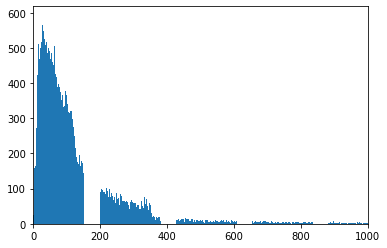

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
print(length_distribution)
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
max_length = 400
data = pd.DataFrame()
data["x"] = x
data["y"] = y
data_length_filtered = data.loc[data["x"].str.len() <= max_length]
print(round(100 * (1.0 - (len(data_length_filtered) / len(data))), 2), "%", "filtered out because of text length")
x,y = data_length_filtered["x"], data_length_filtered["y"]
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

5.69 % filtered out because of text length


In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 2
)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = max_length
)

test_ratio = 0.8
train_size = int(test_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Train dataset class distribution

{1: 25249, 0: 31865}


<BarContainer object of 2 artists>

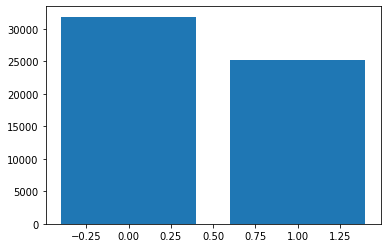

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(train_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:blue")

## Test dataset class distribution

{0: 7890, 1: 6389}


<BarContainer object of 2 artists>

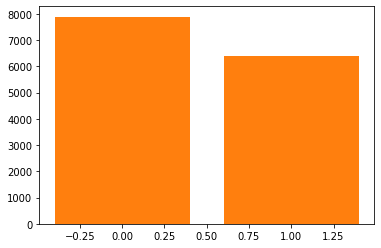

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(test_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:orange")

## Train

In [ ]:
model, stats = train_classifier(
    model = model,
    dataset = train_dataset,
    validation_ratio = 0.9,
    batch_size = 32,
    freeze_embeddings_layer = True,
    freeze_encoder_layers = 8,
    epochs = 3,
    save_checkpoints = True
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,607.    Elapsed: 0:00:46.
  Batch    80  of  1,607.    Elapsed: 0:01:33.
  Batch   120  of  1,607.    Elapsed: 0:02:21.
  Batch   160  of  1,607.    Elapsed: 0:03:10.
  Batch   200  of  1,607.    Elapsed: 0:03:59.
  Batch   240  of  1,607.    Elapsed: 0:04:49.
  Batch   280  of  1,607.    Elapsed: 0:05:39.
  Batch   320  of  1,607.    Elapsed: 0:06:29.
  Batch   360  of  1,607.    Elapsed: 0:07:19.
  Batch   400  of  1,607.    Elapsed: 0:08:10.
  Batch   440  of  1,607.    Elapsed: 0:09:00.
  Batch   480  of  1,607.    Elapsed: 0:09:50.
  Batch   520  of  1,607.    Elapsed: 0:10:41.
  Batch   560  of  1,607.    Elapsed: 0:11:31.
  Batch   600  of  1,607.    Elapsed: 0:12:21.
  Batch   640  of  1,607.    Elapsed: 0:13:12.
  Batch   680  of  1,607.    Elapsed: 0:14:02.
  Batch   720  of  1,607.    Elapsed: 0:14:52.
  Batch   760  of  1,607.    Elapsed: 0:15:43.
  Ba

In [ ]:
model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/checkpoint_e3_2021-04-23 22:05:44.962969.pt")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = test_dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1 | 
---------------------------
  0 |  51.53  3.73 |  55.26
  1 |   4.61 40.14 |  44.74
---------------------------
    |  56.14 43.86 | 

Majority Class                     :  0.5526
Accuracy                           :  0.9167

Sensitivity, Recall                :  0.9326
Specificity                        :  0.8970
Positive Predictive, Precision     :  0.9179
Negative Predictive                :  0.9151
F1 Score                           :  0.9252


**Saving model**

In [ ]:
save_model("drive/MyDrive/models/binary_5_nostop_400.pt", model)

# Multiclass Eng classification

## Setup

In [ ]:
multiclass_data = pd.read_csv('drive/MyDrive/Data/Eng/Multiclass/data.csv')
x,y = run_dataset_preparation(multiclass_data, "eng", remove_stopwords=False, do_lemmatization=True)

Text length distribution

{98: 251, 31: 410, 118: 238, 54: 400, 76: 304, 23: 450, 63: 320, 50: 346, 122: 196, 40: 410, 58: 337, 25: 420, 96: 280, 37: 396, 97: 286, 29: 455, 104: 248, 119: 196, 65: 325, 108: 229, 115: 244, 120: 211, 92: 268, 112: 244, 36: 432, 22: 406, 42: 410, 71: 326, 51: 347, 113: 231, 111: 231, 105: 249, 86: 270, 39: 447, 45: 349, 57: 369, 46: 396, 117: 223, 69: 336, 124: 180, 83: 274, 88: 274, 100: 272, 27: 442, 61: 349, 94: 263, 62: 340, 59: 342, 99: 278, 73: 294, 107: 221, 116: 245, 75: 251, 114: 232, 102: 241, 85: 276, 43: 403, 89: 252, 78: 291, 35: 428, 77: 279, 84: 268, 90: 255, 87: 237, 82: 275, 106: 252, 12: 275, 56: 358, 67: 317, 109: 242, 95: 270, 123: 203, 49: 395, 79: 299, 55: 381, 64: 382, 11: 312, 33: 450, 19: 370, 127: 144, 125: 177, 28: 454, 16: 415, 53: 361, 44: 428, 68: 297, 74: 305, 48: 373, 93: 264, 80: 285, 60: 347, 32: 429, 24: 453, 101: 212, 70: 318, 30: 455, 72: 282, 103: 252, 132: 122, 121: 209, 38: 431, 34: 415, 17: 393, 110: 259, 66: 322, 81: 278, 41: 372, 91: 253,

(0.0, 1000.0)

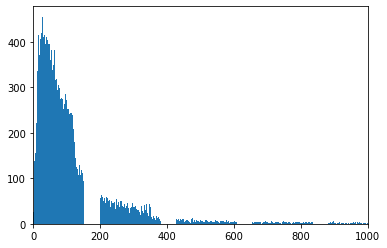

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
print(length_distribution)
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
max_length = 400
data = pd.DataFrame()
data["x"] = x
data["y"] = y
data_length_filtered = data.loc[data["x"].str.len() <= max_length]
print(round(100 * (1.0 - (len(data_length_filtered) / len(data))), 2), "%", "filtered out because of text length")
x,y = data_length_filtered["x"], data_length_filtered["y"]
x.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

5.55 % filtered out because of text length


In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 6
)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = max_length
)

test_ratio = 0.8
train_size = int(test_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

Some weights of the model checkpoint at drive/MyDrive/classifiers/bert/CroSloEngual were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized fr

## Train dataset class distribution

{0: 31766, 2: 5179, 1: 1073, 4: 537, 3: 3035, 5: 280}


<BarContainer object of 6 artists>

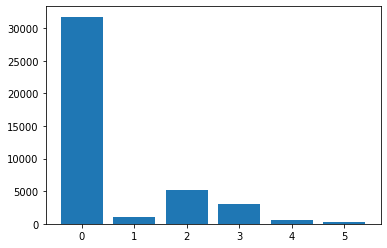

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(train_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:blue")

## Test dataset class distribution

{0: 7989, 5: 81, 3: 756, 2: 1268, 1: 258, 4: 116}


<BarContainer object of 6 artists>

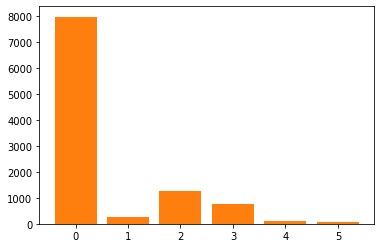

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(test_dataset)])
print(class_distribution)
xv = list(class_distribution.keys())
yv = list(class_distribution.values())
plt.bar(xv, yv, color="tab:orange")

## Train

In [ ]:
model, stats = train_classifier(
    model = model,
    dataset = train_dataset,
    validation_ratio = 0.9,
    batch_size = 32,
    freeze_embeddings_layer = True,
    freeze_encoder_layers = 8,
    epochs = 3,
    save_checkpoints = True
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,178.    Elapsed: 0:00:46.
  Batch    80  of  1,178.    Elapsed: 0:01:33.
  Batch   120  of  1,178.    Elapsed: 0:02:21.
  Batch   160  of  1,178.    Elapsed: 0:03:10.
  Batch   200  of  1,178.    Elapsed: 0:03:59.
  Batch   240  of  1,178.    Elapsed: 0:04:49.
  Batch   280  of  1,178.    Elapsed: 0:05:39.
  Batch   320  of  1,178.    Elapsed: 0:06:29.
  Batch   360  of  1,178.    Elapsed: 0:07:20.
  Batch   400  of  1,178.    Elapsed: 0:08:10.
  Batch   440  of  1,178.    Elapsed: 0:09:00.
  Batch   480  of  1,178.    Elapsed: 0:09:51.
  Batch   520  of  1,178.    Elapsed: 0:10:41.
  Batch   560  of  1,178.    Elapsed: 0:11:31.
  Batch   600  of  1,178.    Elapsed: 0:12:22.
  Batch   640  of  1,178.    Elapsed: 0:13:12.
  Batch   680  of  1,178.    Elapsed: 0:14:03.
  Batch   720  of  1,178.    Elapsed: 0:14:53.
  Batch   760  of  1,178.    Elapsed: 0:15:43.
  Ba

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = test_dataset,
    batch_size = 32
)

There are 1 GPU(s) available.
We will use the GPU: Tesla T4

Running Prediction...
DONE.


## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)


Confusion Matrix
Rows - Actual
Columns - Predicted

    |      0     1     2     3     4     5 | 
---------------------------------------------------
  0 |  74.31  0.33  0.94  0.59  0.08  0.07 |  76.32
  1 |   0.44  1.76  0.07  0.18  0.00  0.02 |   2.46
  2 |   0.20  0.01 11.80  0.07  0.04  0.00 |  12.11
  3 |   0.14  0.24  0.07  6.71  0.02  0.05 |   7.22
  4 |   0.07  0.01  0.07  0.03  0.94  0.00 |   1.11
  5 |   0.19  0.04  0.02  0.27  0.00  0.26 |   0.77
---------------------------------------------------
    |  75.35  2.39 12.95  7.84  1.07  0.39 | 

Majority Class                     :  0.7632
Accuracy                           :  0.9577



**Saving model**

In [ ]:
save_model("drive/MyDrive/models/multiclass.pt", model)

# Binary Slo classification

## Setup

In [ ]:
binary_data = pd.read_csv('drive/MyDrive/Data/Slo/Binary/data.csv')
x,y = run_dataset_preparation(binary_data, "slo", remove_stopwords=False, do_lemmatization=True)

Text length distribution

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
print(length_distribution)
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 2
)

#model.load_state_dict(load_model("drive/MyDrive/models/binary_5_nostop_400.pt"))

model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/binary_checkpoint_e3_2021-04-23 22:05:44.962969.pt")
model.load_state_dict(model_state_dict)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 400
)

## Dataset class distribution

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(dataset)])
print(class_distribution)
yv = list(class_distribution.keys())
xv = list(class_distribution.values())
plt.bar(yv, xv, color="tab:blue")

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = dataset,
    batch_size = 32
)

## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)

# Multiclass Slo classification

## Setup

In [ ]:
multiclass_data = pd.read_csv('drive/MyDrive/Data/Slo/Multiclass/data.csv')
x,y = run_dataset_preparation(multiclass_data, "slo", remove_stopwords=False, do_lemmatization=False)

Text length distribution

In [ ]:
length_distribution = distribution_dataset([len(e) for e in list(x.values)])
print(length_distribution)
xv = list(length_distribution.keys())
yv = list(length_distribution.values())
plt.bar(xv, yv, color="tab:blue")
axes = plt.gca()
axes.set_xlim([0,1000])

In [ ]:
model = setup_classifier(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    num_labels = 6
)

#model.load_state_dict(load_model("drive/MyDrive/models/checkpoint_e2_2021-04-23 23:33:32.776693.pt"))

model_state_dict, _, _, _ = load_checkpoint("drive/MyDrive/models/checkpoint_e2_2021-04-23 23:33:32.776693.pt")
model.load_state_dict(model_state_dict)

dataset = setup_data(
    model_name = "drive/MyDrive/classifiers/bert/CroSloEngual",
    x = x,
    y = y,
    do_lower_case = False,
    max_length = 400
)

## Dataset class distribution

In [ ]:
class_distribution = distribution_dataset([e[2].item() for e in list(dataset)])
print(class_distribution)
yv = list(class_distribution.keys())
xv = list(class_distribution.values())
plt.bar(yv, xv, color="tab:blue")

## Test

In [ ]:
predictions, true_labels = test_classifier(
    model = model,
    dataset = dataset,
    batch_size = 32
)

## Performance

In [ ]:
print_performance_metrics(predictions, true_labels)